### Using this Jupyter Notebook with a local virtualenv (Mac/BSD)

First, clone the repo from GitHub - then, within the project dir:

**Create a virtual env**
1. `python3 -m venv venv` # creates a virtualenv named vend at ./venv
1. `source venv/bin/activate` # activate the venv
1. `type python` # Confirm this points to your venv interpreter, see below
```
(venv) stu@bast osic_kaggle % type python
python is /Users/stu/dev/osic_kaggle/venv/bin/python
```

**Install the runtime**

1. `pip3 install pip --upgrade` # upgrade pip
1. `pip3 install -r requirements.txt` # install dependencies
1. `python3 -m ipykernel install --user --name=osic-kaggle` # create an ipython kernel for the venv

With the virtual env enabled:

1. `jupyter notebook OSIC\ EDA.ipynb` # Start the notebook
1. Within the notebook, select the Kernel options bar > "Change Kernel" > select "osic-kaggle"

Congrats, the notebook should work properly in a virtualenv!

**Deactivate**

At any time, type `deactivate` in your shell to leave the virtualenv scope



### Runtime-dependent Data Imports
In the cell below, uncomment the section corresponding to the runtime you are using.
**Leave all other sections commented!**


In [1]:
# Colab + Google Drive
"""
# Mount Google Drive and authn to it
import glob
from google.colab import drive 

# This is execution-blocking & requires user authentication : Follow the steps as guided 
drive.mount('/content/drive')

DATA_DIR = "/content/drive/My Drive/osic_kaggle/data/"
"""

# Local - adjust to your filesystem as needed
DATA_DIR = "/Users/jesse/Documents/osic_kaggle/data/" # Local

# Shared/Subdirs - you probably don't need to change this
# Quick hackiness instead of using the Path lib
TRAINING_DIR = f"{DATA_DIR}train" if DATA_DIR[-1] == "/" else f"{DATA_DIR}/train"
TESTING_DIR = f"{DATA_DIR}test" if DATA_DIR[-1] == "/" else f"{DATA_DIR}/test"


### Runtime-dependent lib installation
If running in a local / virtualenv, you should use `pip3 install -r requirements.txt` to install dependencies.

If running in Google Colab, uncomment the below cell to install dependencies

In [2]:
# !pip install numpy pandas seaborn pydicom matplotlib tqdm

In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import pydicom
from pathlib import Path
import matplotlib.pyplot as plt
import tqdm
import random

In [4]:
sns.set_style('whitegrid')


# Tabular Data
**clinical patient info and FVC**
- Patient (str): a unique Id for each patient (also the name of the patient's DICOM folder)
- Weeks (int): the relative number of weeks pre/post the baseline CT (may be negative)
- FVC (int): the recorded lung capacity in ml
- Percent (float): a computed field which approximates the patient's FVC as a percent of the typical FVC for a person of similar characteristics
- Age (int)
- Sex (str)
- SmokingStatus (str)

In [5]:
# use the previously set DATA_DIR
train_df = pd.read_csv(DATA_DIR + 'train.csv')
test_df = pd.read_csv(DATA_DIR + 'test.csv')
print(train_df.shape)
print(test_df.shape)
train_df.head()

(1549, 7)
(5, 7)


Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker

In [13]:
print(f"Found {train_df['Patient'].nunique()} unique patients")

Found 176 unique patients


In [44]:
# test train overlap
# all 5 test cases are taken directly from the training df. Don't bother using the testing dataset ever.
overlapping_patients = list(set(train_df['Patient'].tolist()).intersection(set(test_df['Patient'].tolist())))
print(train_df[train_df['Patient']==overlapping_patients[0]]['Weeks'])
print(test_df[test_df['Patient']==overlapping_patients[0]]['Weeks'])

1531    17
1532    18
1533    19
1534    21
1535    23
1536    30
1537    42
1538    53
1539    70
Name: Weeks, dtype: int64
3    17
Name: Weeks, dtype: int64


### Distribution of FVC measurements

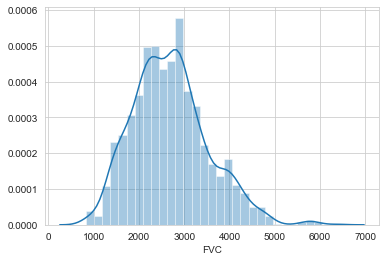

In [14]:
sns.scatterplot(data = train_df, x='Age', y='FVC', hue = 'Sex', alpha=.5);

C:\ProgramData\Anaconda3\envs\OSIC_EDA\lib\site-packages\seaborn\axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


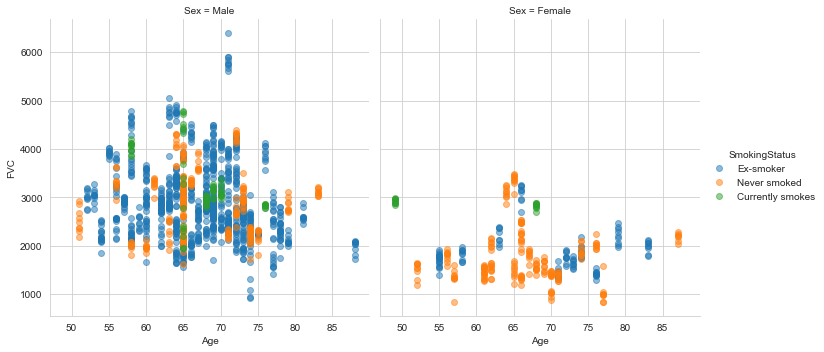

In [6]:
g = sns.FacetGrid(data = train_df, col='Sex', hue='SmokingStatus', size=5, aspect=1);
g = (g.map(plt.scatter, 'Age', 'FVC' ,alpha=.5).add_legend())

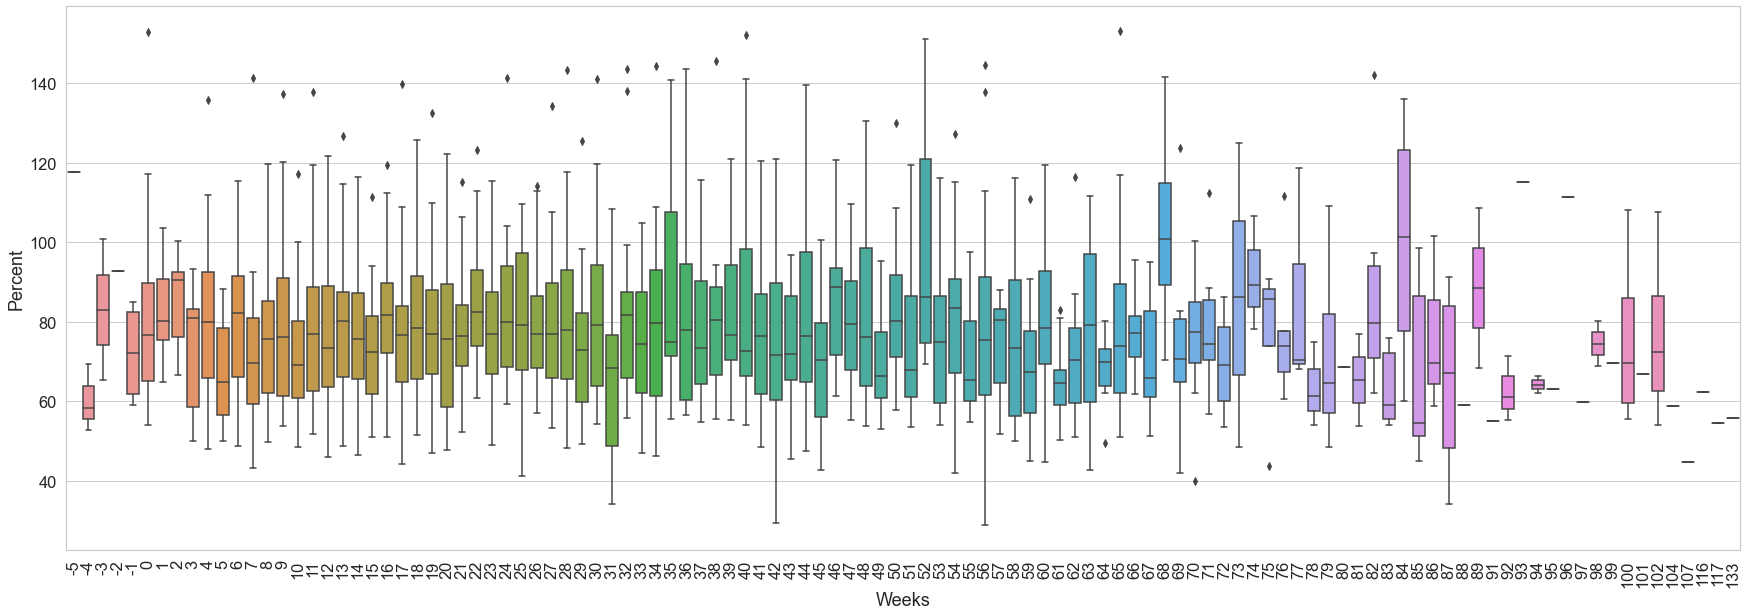

In [15]:
with sns.plotting_context("notebook",font_scale=1.5):
    fig, ax = plt.subplots(figsize=(30, 10))
    sns.boxplot(data=train_df, x='Weeks', y='Percent', ax=ax);
    plt.xticks(rotation=90);

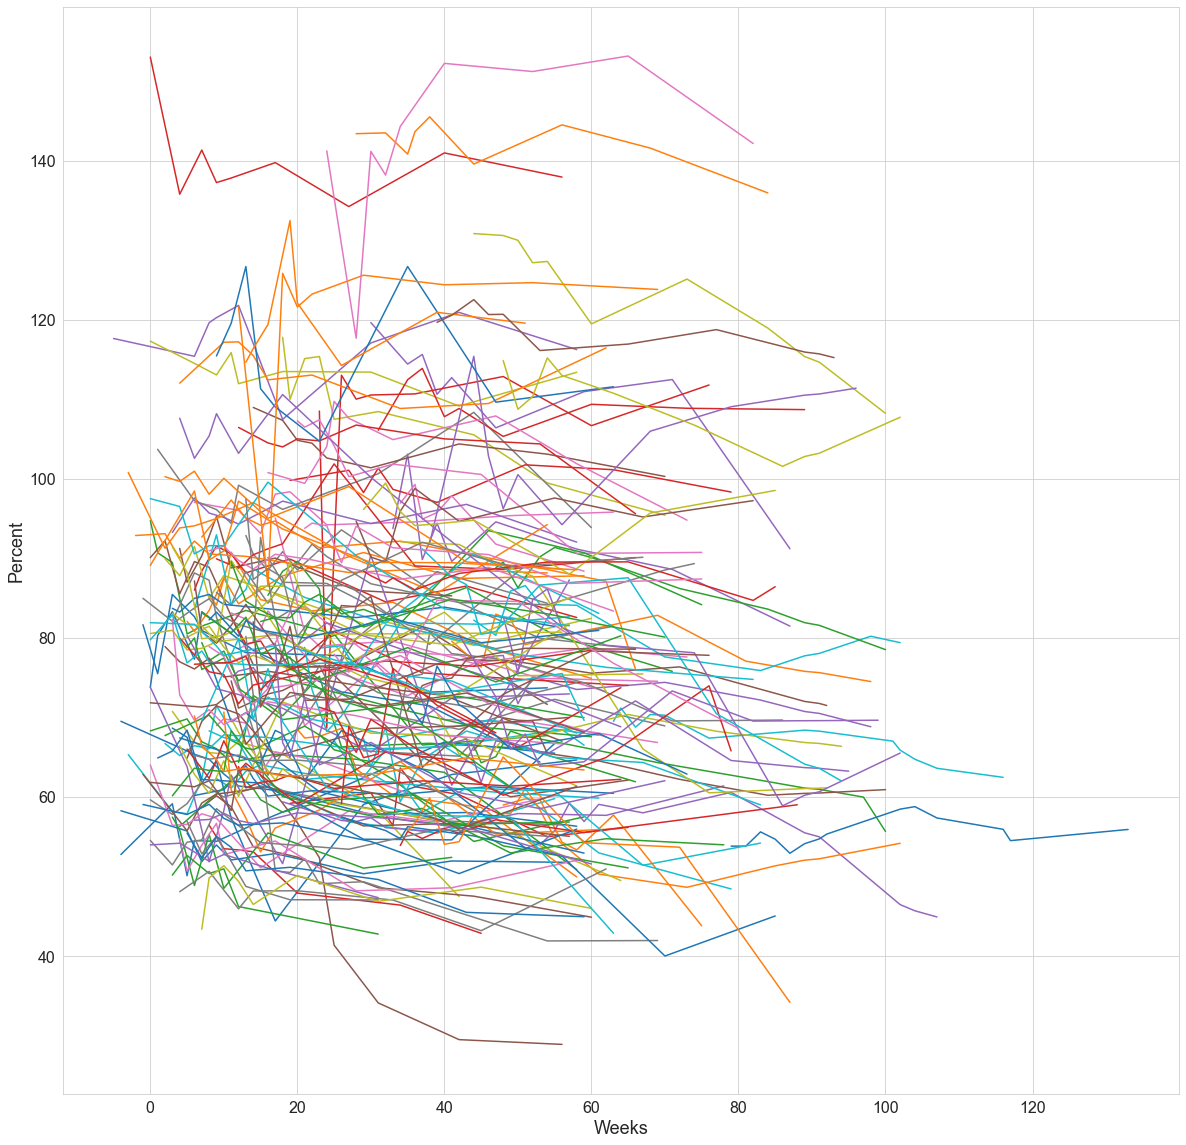

In [13]:
fig, ax = plt.subplots(figsize=(20,20))
train_df.groupby(['Weeks','Patient'])['Percent']\
    .median()\
    .unstack()\
    .interpolate(method='linear', limit_area='inside')\
    .plot(ax=ax,legend=None);
plt.ylabel('Percent', fontsize=18);
plt.yticks(fontsize=16);
plt.xlabel('Weeks', fontsize=18);
plt.xticks(fontsize=16);

### Distribution of Age

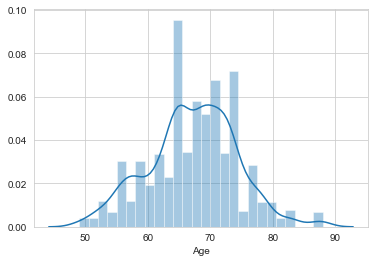

In [14]:
sns.distplot(train_df['Age']);

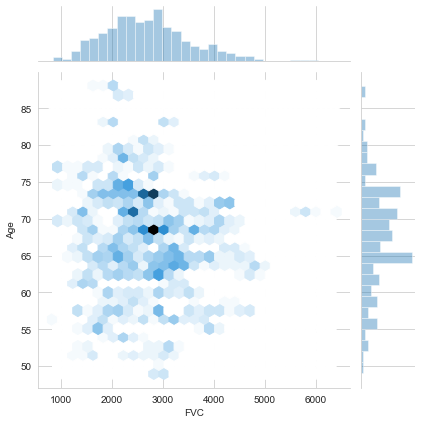

In [16]:
sns.jointplot(x="FVC", y="Age", data=train_df, kind="hex");

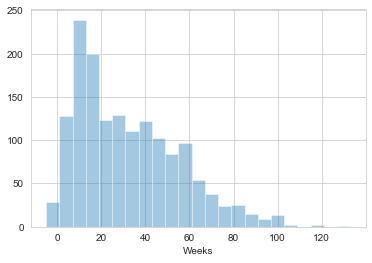

In [17]:
sns.distplot(train_df['Weeks'], kde=False);

## DICOM Data

In [7]:
# Use the previously set training dir
train_dcms =  [path for path in Path(TRAINING_DIR).rglob('*.dcm')]
train_folders = os.listdir(TRAINING_DIR)
print(f'training set has {len(train_dcms)} total images, comprising {len(train_folders)} patients')

training set has 33026 total images, comprising 176 patients


In [8]:
# read a single DICOM header. OF NOTE:
# (0020, 0032) Image Position (Patient)     DS: [-158.700, -153.500, -69.750] --- x,y,z of image w.r.t. patient
# (0028, 0004) Photometric Interpretation   CS: 'MONOCHROME2' --- dark vs light value
# (0028, 1050) Window Center                DS: "-500.0" --- brightness
# (0028, 1051) Window Width                 DS: "-1500.0" --- contrast
# (7fe0, 0010) Pixel Data                   OW: Array of 524288 elements --- pixel data as byte array
print(train_dcms[0])
dimg = pydicom.dcmread(train_dcms[0])
dimg

/Users/jesse/Documents/osic_kaggle/data/train/ID00296637202279895784347/16.dcm


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 2.25.12779743606216391659179055517331126608
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.1
(0002, 0013) Implementation Version Name         SH: 'OSIRIX_361'
(0002, 0016) Source Application Entity Title     AE: 'ANONYMOUS'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0018) SOP Instance UID                    UI: 2.25.12779743606216391659179055517331126608
(0008, 0060) Modality                            CS: 'CT'
(000

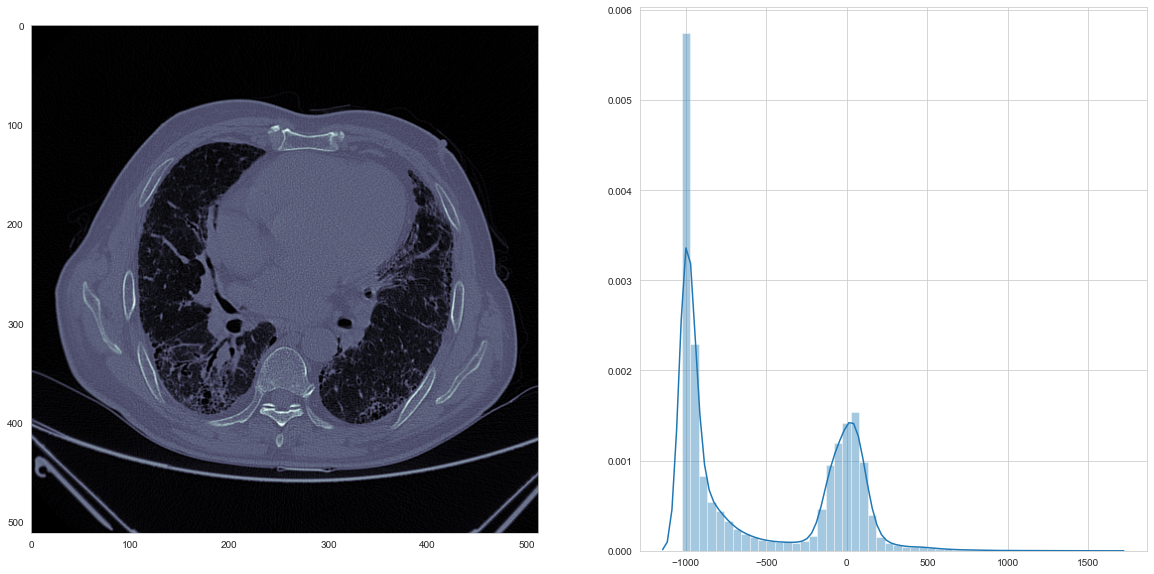

In [9]:
# plot a single image
# low values appear as dark, high values as light (MONOCHROME2)
fig, axes = plt.subplots(1,2,figsize=(20,10))
axes[0].imshow(dimg.pixel_array, cmap=plt.cm.bone)
axes[0].grid(False);
sns.distplot(dimg.pixel_array.flatten(), ax=axes[1]);

In [181]:
# Function to rescale pixels to common Hounsfield Units scale (https://en.wikipedia.org/wiki/Hounsfield_scale)
# Air: -1000
# Water: 0
# Bone: 300-3000
# Metal: 2000
def hu_scaled_px(dicom_image):
    # rescales per rescale slope and intercept
    img = dicom_image.pixel_array
    return img if dicom_image.Modality == "CR" else img * dicom_image.RescaleSlope + dicom_image.RescaleIntercept
hu_scaled_px(dimg)

array([[-1024., -1024., -1024., ..., -1024., -1024., -1024.],
       [-1024., -1024., -1024., ..., -1024.,  -919., -1024.],
       [-1024., -1024., -1024., ..., -1000.,  -982.,  -999.],
       ...,
       [-1024., -1024., -1024., ..., -1009.,  -974.,  -995.],
       [-1024., -1024., -1024., ..., -1014.,  -994., -1024.],
       [-1024., -1024., -1024., ..., -1024., -1024., -1024.]])

In [10]:
row_dict = {
    'Patient':'PatientID',
    'body_part_examined':'BodyPartExamined',
    'image_position_patient':  'ImagePositionPatient',
    'image_orientation_patient':  'ImageOrientationPatient',
    'photometric_interpretation':  'PhotometricInterpretation',
    'rows':  'Rows',
    'columns':  'Columns',
    'pixel_spacing':  'PixelSpacing',
    'window_center':  'WindowCenter',
    'window_width':  'WindowWidth',
    'modality':  'Modality',
    'StudyInstanceUID':  'StudyInstanceUID',
    'SeriesInstanceUID':  'StudyInstanceUID',
    'StudyID':  'StudyInstanceUID', 
    'SamplesPerPixel':  'SamplesPerPixel',
    'BitsAllocated':  'BitsAllocated',
    'BitsStored':  'BitsStored',
    'HighBit':  'HighBit',
    'PixelRepresentation':  'PixelRepresentation',
    'RescaleIntercept':  'RescaleIntercept',
    'RescaleSlope':  'RescaleSlope',
    'SliceThickness': 'SliceThickness',
    'SpacingBetweenSlices': 'SpacingBetweenSlices'}

def extract_dicom_meta_data(filename: str) -> dict:
    # Load image
    
    image_data = pydicom.read_file(filename, stop_before_pixels=True)

    row = pd.Series()
    for key, val in row_dict.items():
        try:
            row[key] = image_data.get(val)
        except:
            row[key] = np.nan

    return row

In [11]:
meta_data_df = []
error_log = []
for filename in tqdm.tqdm(train_dcms):
    try:
        meta_data_df.append(extract_dicom_meta_data(filename))
    except Exception as e:
        error_log.append((filename, e))
        continue
        
# Convert to a pd.DataFrame from dict
meta_data_df = pd.DataFrame.from_dict(meta_data_df)
meta_data_df.to_csv('meta_data_df.csv', index=False)
meta_data_df.head()

100%|██████████| 33026/33026 [09:36<00:00, 57.27it/s]


Patient body_part_examined    image_position_patient  \
0  ID00296637202279895784347              Chest  [-198, -35, -491.099976]   
1  ID00296637202279895784347              Chest  [-198, -35, -501.099976]   
2  ID00296637202279895784347              Chest  [-198, -35, -481.099976]   
3  ID00296637202279895784347              Chest  [-198, -35, -621.099976]   
4  ID00296637202279895784347              Chest  [-198, -35, -611.099976]   

  image_orientation_patient photometric_interpretation  rows  columns  \
0        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
1        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
2        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
3        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   
4        [1, 0, 0, 0, 1, 0]                MONOCHROME2   512      512   

          pixel_spacing window_center window_width  ...  \
0  [0.714844, 0.714844]          -500        -1500  ...   
1  [0.714844, 0.714844]          -500        -1500  ...   
2  [0.714844, 0.714844]          -500        -1500  ...   
3  [0.714844, 0.714844]          -500        -1500  ...   
4  [0.714844, 0.714844]          -500        -1500  ...   

                                        StudyID SamplesPerPixel BitsAllocated  \
0  2.25.134212600069851928291265402780380633900               1            16   
1  2.25.134212600069851928291265402780380633900               1            16   
2  2.25.134212600069851928291265402780380633900               1            16   
3  2.25.134212600069851928291265402780380633900               1            16   
4  2.25.134212600069851928291265402780380633900               1            16   

  BitsStored  HighBit  PixelRepresentation  RescaleIntercept  RescaleSlope  \
0         16       15                    1               0.0           1.0   
1         16       15                    1               0.0           1.0   
2         16       15                    1               0.0           1.0   
3         16       15                    1               0.0           1.0   
4         16       15                    1               0.0           1.0   

   SliceThickness  SpacingBetweenSlices  
0             1.0                 -10.0  
1             1.0                 -10.0  
2             1.0                 -10.0  
3             1.0                 -10.0  
4             1.0                 -10.0  

[5 rows x 23 columns]

In [12]:
len(error_log)

0

In [13]:
# examine dataframe
meta_data_df.columns

Index(['Patient', 'body_part_examined', 'image_position_patient',
       'image_orientation_patient', 'photometric_interpretation', 'rows',
       'columns', 'pixel_spacing', 'window_center', 'window_width', 'modality',
       'StudyInstanceUID', 'SeriesInstanceUID', 'StudyID', 'SamplesPerPixel',
       'BitsAllocated', 'BitsStored', 'HighBit', 'PixelRepresentation',
       'RescaleIntercept', 'RescaleSlope', 'SliceThickness',
       'SpacingBetweenSlices'],
      dtype='object')

In [134]:
meta_data_df['photometric_interpretation'].value_counts()

MONOCHROME2    33026
Name: photometric_interpretation, dtype: int64

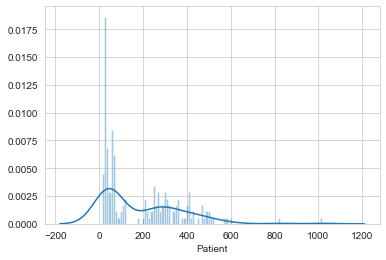

In [40]:
# number of CT images per patient
sns.distplot(meta_data_df['Patient'].value_counts(), bins=100);

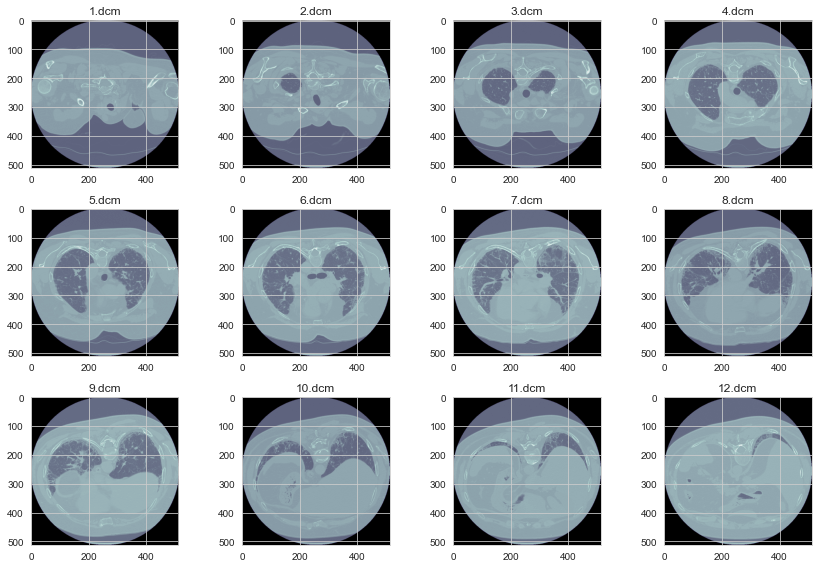

In [88]:
# examine the scans from a patient with very few CTs
p = meta_data_df['Patient'].value_counts().sort_values(ascending=True).index[0]

# meta_df rows
# meta_data_df[meta_data_df['Patient']==p]

# view actual CTs
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
p_dicoms_sorted = sorted(p_dicoms, key=lambda i: int(os.path.splitext(os.path.basename(i))[0]))
rows, cols = 3, 4
fig, ax = plt.subplots(rows,cols, figsize=(12, 8))
for i, dicom in enumerate(p_dicoms_sorted):
    img = pydicom.dcmread(dicom)
    ax[i // cols, i % cols].imshow(hu_scaled_px(img), cmap=plt.cm.bone);
    ax[i // cols, i % cols].set_title(os.path.basename(dicom))
plt.tight_layout()

In [49]:
meta_data_df['SpacingBetweenSlices'].value_counts()

 1.000     2542
-1.000     1564
 0.700     1291
 0.500     1018
 5.000      882
 1.500      524
 20.000     524
 0.625      521
 0.750      469
-0.800      451
-0.700      320
 0.400      295
 1.250      273
-5.000      131
-10.000     128
 2.500       97
 10.000      30
 15.000      22
Name: SpacingBetweenSlices, dtype: int64

In [20]:
# investigate image orientation [Xx, Xy, Xz, Yx, Yy, Yz]
# X plane: viewing patient's front
# Y plane: viewing patient from side
print(f"Found {meta_data_df['image_orientation_patient'].isna().sum()} null orientations")
meta_data_df['image_orientation_patient'] = \
    meta_data_df['image_orientation_patient'].dropna().apply(lambda x: [int(a) for a in x])
meta_data_df['image_orientation_patient'].value_counts()

Found 455 null orientations


[1, 0, 0, 0, 1, 0]      31791
[-1, 0, 0, 0, -1, 0]      627
[1, 0, 0, 0, -1, 0]        62
[0, 0, 0, 0, 1, 0]         53
[-1, 0, 0, 0, 1, 0]        38
Name: image_orientation_patient, dtype: int64

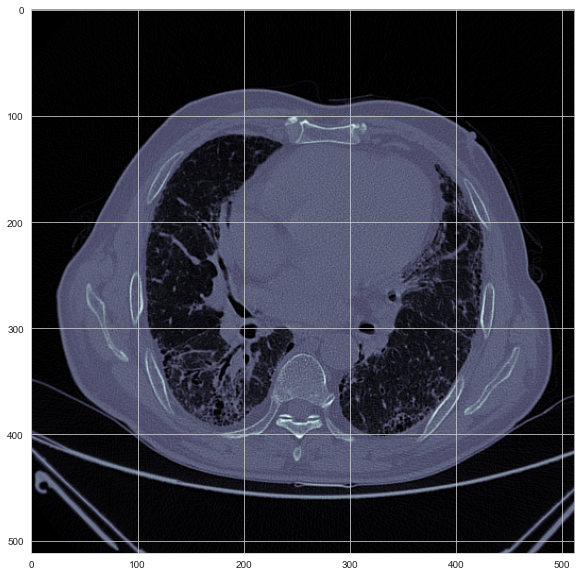

In [39]:
# exmaple of atypical image orientation 
# in [-1, 0, 0, 0, -1, 0], Xx is reversed, Yy is reversed: scans be rotated 180
p = meta_data_df[meta_data_df['image_orientation_patient'].apply(str)==str([-1, 0, 0, 0, -1, 0])].iloc[0]['Patient']
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
img = pydicom.dcmread(p_dicoms[0])
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.imshow(dimg.pixel_array, cmap=plt.cm.bone);

In [84]:
meta_data_df['SliceThickness'].value_counts()

1.000000    12280
1.250000     5682
0.625000     4381
0.500000     2967
2.000000     2561
5.000000     1224
3.000000     1169
0.750000      812
1.500000      676
2.500000      474
0.900000      320
0.800000      295
7.000000       85
6.500000       61
8.000000       38
0.835938        1
Name: SliceThickness, dtype: int64

In [92]:
meta_data_df.groupby('Patient')['SpacingBetweenSlices'].nunique()

Patient
ID00007637202177411956430    0
ID00009637202177434476278    0
ID00010637202177584971671    0
ID00011637202177653955184    0
ID00012637202177665765362    0
                            ..
ID00419637202311204720264    0
ID00421637202311550012437    0
ID00422637202311677017371    1
ID00423637202312137826377    1
ID00426637202313170790466    1
Name: SpacingBetweenSlices, Length: 176, dtype: int64

In [93]:
meta_data_df[meta_data_df['Patient']=='ID00007637202177411956430']

Patient body_part_examined  \
24394  ID00007637202177411956430              Chest   
24395  ID00007637202177411956430              Chest   
24396  ID00007637202177411956430              Chest   
24397  ID00007637202177411956430              Chest   
24398  ID00007637202177411956430              Chest   
24399  ID00007637202177411956430              Chest   
24400  ID00007637202177411956430              Chest   
24401  ID00007637202177411956430              Chest   
24402  ID00007637202177411956430              Chest   
24403  ID00007637202177411956430              Chest   
24404  ID00007637202177411956430              Chest   
24405  ID00007637202177411956430              Chest   
24406  ID00007637202177411956430              Chest   
24407  ID00007637202177411956430              Chest   
24408  ID00007637202177411956430              Chest   
24409  ID00007637202177411956430              Chest   
24410  ID00007637202177411956430              Chest   
24411  ID00007637202177411956430              Chest   
24412  ID00007637202177411956430              Chest   
24413  ID00007637202177411956430              Chest   
24414  ID00007637202177411956430              Chest   
24415  ID00007637202177411956430              Chest   
24416  ID00007637202177411956430              Chest   
24417  ID00007637202177411956430              Chest   
24418  ID00007637202177411956430              Chest   
24419  ID00007637202177411956430              Chest   
24420  ID00007637202177411956430              Chest   
24421  ID00007637202177411956430              Chest   
24422  ID00007637202177411956430              Chest   
24423  ID00007637202177411956430              Chest   

               image_position_patient image_orientation_patient  \
24394  [-158.700, -153.500, -219.750]        [1, 0, 0, 0, 1, 0]   
24395  [-158.700, -153.500, -229.750]        [1, 0, 0, 0, 1, 0]   
24396  [-158.700, -153.500, -209.750]        [1, 0, 0, 0, 1, 0]   
24397  [-158.700, -153.500, -349.750]        [1, 0, 0, 0, 1, 0]   
24398  [-158.700, -153.500, -339.750]        [1, 0, 0, 0, 1, 0]   
24399  [-158.700, -153.500, -199.750]        [1, 0, 0, 0, 1, 0]   
24400  [-158.700, -153.500, -159.750]        [1, 0, 0, 0, 1, 0]   
24401  [-158.700, -153.500, -169.750]        [1, 0, 0, 0, 1, 0]   
24402  [-158.700, -153.500, -189.750]        [1, 0, 0, 0, 1, 0]   
24403  [-158.700, -153.500, -179.750]        [1, 0, 0, 0, 1, 0]   
24404  [-158.700, -153.500, -149.750]        [1, 0, 0, 0, 1, 0]   
24405  [-158.700, -153.500, -139.750]        [1, 0, 0, 0, 1, 0]   
24406  [-158.700, -153.500, -119.750]        [1, 0, 0, 0, 1, 0]   
24407  [-158.700, -153.500, -129.750]        [1, 0, 0, 0, 1, 0]   
24408  [-158.700, -153.500, -109.750]        [1, 0, 0, 0, 1, 0]   
24409   [-158.700, -153.500, -99.750]        [1, 0, 0, 0, 1, 0]   
24410   [-158.700, -153.500, -69.750]        [1, 0, 0, 0, 1, 0]   
24411   [-158.700, -153.500, -89.750]        [1, 0, 0, 0, 1, 0]   
24412   [-158.700, -153.500, -79.750]        [1, 0, 0, 0, 1, 0]   
24413  [-158.700, -153.500, -289.750]        [1, 0, 0, 0, 1, 0]   
24414  [-158.700, -153.500, -279.750]        [1, 0, 0, 0, 1, 0]   
24415  [-158.700, -153.500, -259.750]        [1, 0, 0, 0, 1, 0]   
24416  [-158.700, -153.500, -269.750]        [1, 0, 0, 0, 1, 0]   
24417  [-158.700, -153.500, -249.750]        [1, 0, 0, 0, 1, 0]   
24418  [-158.700, -153.500, -309.750]        [1, 0, 0, 0, 1, 0]   
24419  [-158.700, -153.500, -299.750]        [1, 0, 0, 0, 1, 0]   
24420  [-158.700, -153.500, -359.750]        [1, 0, 0, 0, 1, 0]   
24421  [-158.700, -153.500, -239.750]        [1, 0, 0, 0, 1, 0]   
24422  [-158.700, -153.500, -319.750]        [1, 0, 0, 0, 1, 0]   
24423  [-158.700, -153.500, -329.750]        [1, 0, 0, 0, 1, 0]   

      photometric_interpretation  rows  columns         pixel_spacing  \
24394                MONOCHROME2   512      512  [0.652344, 0.652344]   
24395                MONOCHROME2   512      512  [0.652344, 0.652344]   
24396                M

In [30]:
meta_data_df.groupby(['window_center','window_width']).size()

window_center  window_width
-1565.0         1383.0           238
-500.0         -1500.0         30424
                1400.0          1247
                1500.0           629
dtype: int64

In [111]:
meta_data_df['window_width'].isna().sum()

0

In [ ]:
# TODO: create formal training-testing dataframe with uniform orientation + window center/width
# 

In [42]:
#Plot 3 comparisons
def plot_comparison3(df, feature, feature1, feature2):
    "Plot 3 comparisons from a dataframe"
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (25, 4))
    s1 = sns.countplot(df[feature], ax=ax1)
    s1.set_title(feature)
    s2 = sns.countplot(df[feature1], ax=ax2)
    s2.set_title(feature1)
    s3 = sns.countplot(df[feature2], ax=ax3)
    s3.set_title(feature2)
    plt.show()

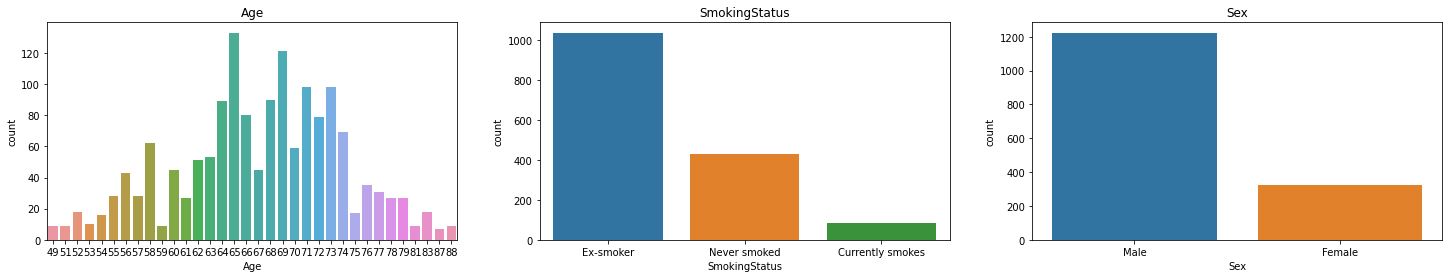

In [44]:
plot_comparison3(train_df, "Age", "SmokingStatus", "Sex")

In [46]:
patient_01 = train_df[train_df.Patient == 'ID00007637202177411956430']
patient_01

Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker
5  ID00007637202177411956430     17  2101  52.868646   79  Male     Ex-smoker
6  ID00007637202177411956430     29  2000  50.327126   79  Male     Ex-smoker
7  ID00007637202177411956430     41  2064  51.937594   79  Male     Ex-smoker
8  ID00007637202177411956430     57  2057  51.761449   79  Male     Ex-smoker

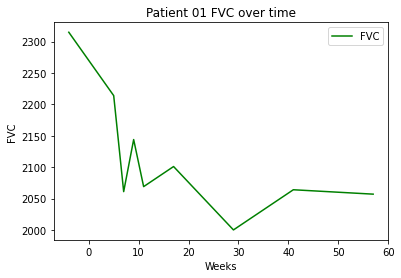

In [53]:
patient_01.plot(kind='line',x='Weeks',y='FVC',color='green')
plt.ylabel("FVC")
plt.title("Patient 01 FVC over time")
plt.show()

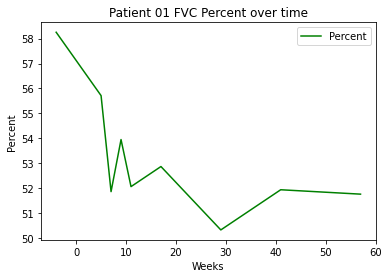

In [54]:
patient_01.plot(kind='line',x='Weeks',y='Percent',color='green')
plt.ylabel("Percent")
plt.title("Patient 01 FVC Percent over time")
plt.show()

In [171]:
meta_data_df['window_width'].value_counts(normalize=True)

-1500.0        0.921244
1400.0         0.037758
1500.0         0.019046
2047.0         0.012324
1383.0         0.007237
1858.0         0.001453
[1500, 350]    0.000878
[1500, 350]    0.000061
Name: window_width, dtype: float64

In [397]:
# lungmask experimenting
#Standardize the pixel values

from skimage import morphology, measure
from sklearn.cluster import KMeans
def make_lungmask(img, display=False):
    '''
    - Standardize the pixel value by subtracting the mean and dividing by the standard deviation
    - Identify the proper threshold by creating 2 KMeans clusters comparing centered on soft tissue/bone vs lung/air.
    - Use Erosion and Dilation which has the net effect of removing tiny features like pulmonary vessels or noise
    - Identify each distinct region as separate image labels (think the magic wand in Photoshop)
    - Using bounding boxes for each image label to identify which ones represent lung and which ones represent "every thing else"
    - Create the masks for lung fields.
    - Apply mask onto the original image to erase voxels outside of the lung fields.
    INPUTS:
        img (np.array): pixel array containing a lung
        display (bool): plotting purposes only
    RETURN:
        (np.array): masked image pixel array
    '''
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs to renormalize washed out images.
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # To improve threshold finding, I'm moving the underflow and overflow on the pixel spectrum
    img[img==max]=mean
    img[img==min]=mean
    # Use Kmeans to separate foreground (soft tissue / bone) and background (lung/air)
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image

    # First erode away the finer elements, then dilate to include some of the pixels surrounding the lung.  
    # We don't want to accidentally clip the lung.
    erosion = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(erosion,np.ones([15,15]))

    labels = measure.label(dilation) # Different labels are displayed in different colors
    labels = labels + 1 # add 1 to every element so that the background is no longer encoded as 0
    label_vals = np.unique(labels)
    # print(label_vals)
    regions = measure.regionprops(labels) # for some reason ignores labels marked 0
    good_labels = []
    n_px = len(img.flatten())
    for prop in regions:
        B = prop.bbox # (min_row, min_col, max_row, max_col)
        # region width < 90% of img
        # region height < 90% of img
        # min row > 15%, max row < 85%
        # min col < 15%, max col < 85%
        # region area is > 0.1% of img
        if B[2]-B[0]<row_size*.90 and \
            B[3]-B[1]<col_size*.90 and \
            B[0]>row_size*.075 and B[2]<row_size*.925 and \
            B[1]>col_size*.075 and B[3]<col_size*925 and \
            prop.area/n_px*100 > 0.1:
            good_labels.append(prop.label) 
            print(f'prop {prop.label} area: {np.round(prop.area/n_px*100,2)}, {B}')
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([5,5])) # one last dilation

    # final masked image
    masked_img = mask*img
    mask_var = np.round(np.var(mask), 4)
    mask_pct = np.mean(mask)
    n_labels = len(good_labels)

    if (display):
        fig, ax = plt.subplots(3, 2, figsize=[8, 12])
        ax[0, 0].set_title("Original")
        ax[0, 0].imshow(img, cmap='gray')
        ax[0, 0].axis('off')
        ax[0, 1].set_title("Threshold")
        ax[0, 1].imshow(thresh_img, cmap='gray')
        ax[0, 1].axis('off')
        ax[1, 0].set_title("After Erosion and Dilation")
        ax[1, 0].imshow(dilation, cmap='gray')
        ax[1, 0].axis('off')
        ax[1, 1].set_title("Color Labels")
        ax[1, 1].imshow(labels)
        ax[1, 1].axis('off')
        ax[2, 0].set_title("Final Mask")
        ax[2, 0].imshow(mask, cmap='gray')
        ax[2, 0].axis('off')
        ax[2, 1].set_title("Apply Mask on Original")
        ax[2, 1].imshow(masked_img, cmap='gray')
        ax[2, 1].axis('off')
        
        plt.show()
    return masked_img, mask_var, mask_pct, n_labels

prop 1: 183, 467
460.8,102.4, 460.8, 102.4
prop 2: 229, 155
460.8,102.4, 460.8, 102.4
prop 3: 241, 223
460.8,102.4, 460.8, 102.4
prop 4: 14, 27
460.8,102.4, 460.8, 102.4
prop 5: 169, 479
460.8,102.4, 460.8, 102.4
prop 6: 13, 9
460.8,102.4, 460.8, 102.4
prop 7: 9, 9
460.8,102.4, 460.8, 102.4


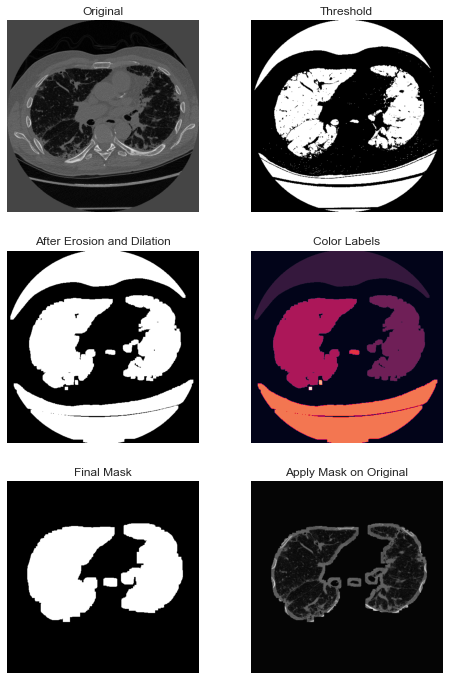

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [230]:
p = 'ID00007637202177411956430'
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
img = pydicom.dcmread(p_dicoms[0])
make_lungmask(img.pixel_array, True)

In [120]:
# testing of windowing function
def dicom_windowing(img, window_center, window_width, ymin, ymax):
    """
    After the modality transform has been applied (rescale slope/intercept or LUT) then the window width/center
    specify which pixels should be visible: all the pixels outside the values specified by the window are
    displayed as black or white.

    https://stackoverflow.com/questions/10193971/rescale-slope-and-rescale-intercept
    Windows a CT slice.
    Per:
    http://dicom.nema.org/medical/dicom/current/output/chtml/part03/sect_C.11.2.html#sect_C.11.2.1.2
    which states:
    These Attributes are applied according to the following pseudo-code, where
    x is the input value,
    y is an output value with a range from ymin to ymax,
    c is Window Center (0028,1050) and
    w is Window Width (0028,1051):

        if (x <= c - 0.5 - (w-1) /2), then y = ymin
        else if (x > c - 0.5 + (w-1) /2), then y = ymax
        else y = ((x - (c - 0.5)) / (w-1) + 0.5) * (ymax- ymin) + ymin

    Returns:
        Windowed slice.
    """
    c = window_center
    print(f'window center: {c}')
    w = window_width
    print(f'window width {w}')
    y = np.zeros_like(img)
    # windowing C.11.2.1.2.1 Default LINEAR Function
    crit1 = (c - 0.5 - (w - 1) / 2)
    print(f'crit1: {crit1}')
    crit2 = (c - 0.5 + (w - 1) / 2)
    print(f'crit2: {crit2}')
    y[img <= crit1] = ymin
    y1 = y
    y[img > crit2] = ymax
    y2 = y
    y[(img > crit1) & (img <= crit2)] = \
        ((img[(img > crit1) & (img <= crit2)] - (c - 0.5)) / (w - 1) + 0.5) * (
                ymax - ymin) + ymin

    return y, y1, y2

window center: -500
window width 1500
crit1: -1250.0
crit2: 249.0


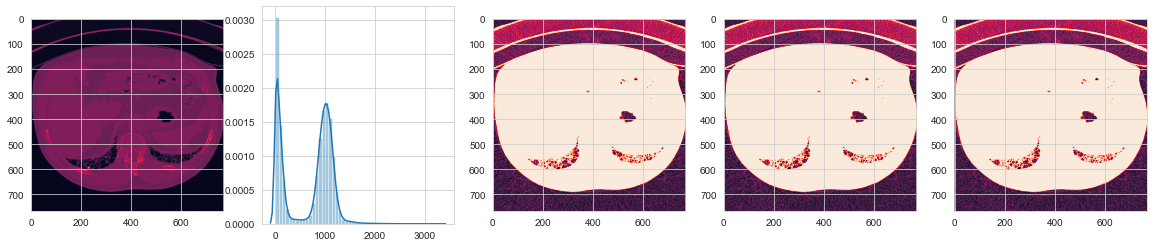

In [233]:
p = 'ID00421637202311550012437'
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
img = pydicom.dcmread(p_dicoms[22])
y, y1, y2 = dicom_windowing(img.pixel_array, img.WindowCenter, img.WindowWidth, -1000, 1000)
fig, axes = plt.subplots(1, 5, figsize = (20, 4))
axes[0].imshow(img.pixel_array)
sns.distplot(img.pixel_array.flatten(), ax=axes[1])
axes[2].imshow(y1)
axes[3].imshow(y2)
axes[4].imshow(y)

In [144]:
def simple_windowing(img: np.array, ymin=-1000, ymax=3000) -> np.array:
    '''
    Naive dicom windowing. Simply windows, does not rescale. To be done after HU rescale
    Inputs:
        img (np.array): original image pixel array, 1d
        ymin (int): minimum cutoff val
        ymax (int): maximum cutoff val
    Returns:
        (np.array)
    '''
    img = np.where(img > ymin, img, ymin)
    img = np.where(img < ymax, img, ymax)
    return img

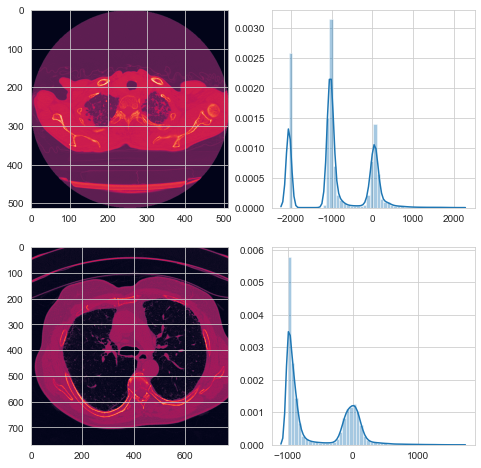

In [217]:
p = random.choice(meta_data_df['Patient'].unique())
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
p_dicom = random.choice(p_dicoms)
img = pydicom.dcmread(p_dicom)
hu_px = hu_scaled_px(img)
post_window_px = simple_windowing(hu_px)
fig, axes = plt.subplots(2, 2, figsize = (8, 8))
axes[0][0].imshow(px);
sns.distplot(px.flatten(), ax=axes[0][1]);
axes[1][0].imshow(post_window_px);
sns.distplot(post_window_px.flatten(), ax=axes[1][1]);
ax[1][1].axvline(img.WindowCenter, c='red');

In [218]:
print(p_dicom)
print(f'RescaleSlope: {img.RescaleSlope}')
print(f'RescaleIntercept: {img.RescaleIntercept}')
print(f'WindowCenter: {img.WindowCenter}')
print(f'WindowWidth: {img.WindowWidth}')

/Users/jesse/Documents/osic_kaggle/data/train/ID00421637202311550012437/22.dcm
RescaleSlope: 1.000000
RescaleIntercept: -1024
WindowCenter: -500
WindowWidth: 1500


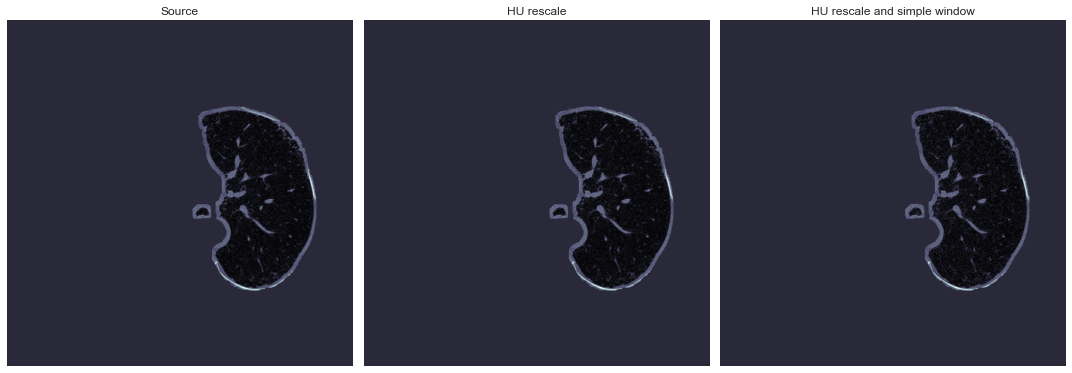

In [219]:
source_mask = make_lungmask(img.pixel_array)
hu_only_mask = make_lungmask(hu_px)
hu_and_window_mask = make_lungmask(post_window_px)

fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(source_mask, cmap='bone');
axes[0].set_title('Source');
axes[0].axis('off');
axes[1].imshow(hu_only_mask, cmap='bone');
axes[1].set_title('HU rescale');
axes[1].axis('off');
axes[2].imshow(hu_and_window_mask, cmap='bone');
axes[2].set_title('HU rescale and simple window');
axes[2].axis('off');
plt.tight_layout()

In [ ]:
# failed for
/Users/jesse/Documents/osic_kaggle/data/train/ID00421637202311550012437/22.dcm

[1 2 3 4 5]
prop 1: 703, 768
703<691.2 and 768<691.2 and 0>153.6 and 703<614.4
prop 2: 768, 768
768<691.2 and 768<691.2 and 0>153.6 and 768<614.4
prop 3: 400, 253
400<691.2 and 253<691.2 and 197>153.6 and 597<614.4
prop 4: 404, 303
404<691.2 and 303<691.2 and 235>153.6 and 639<614.4
prop 5: 23, 32
23<691.2 and 32<691.2 and 414>153.6 and 437<614.4
good labels: [3, 4, 5]


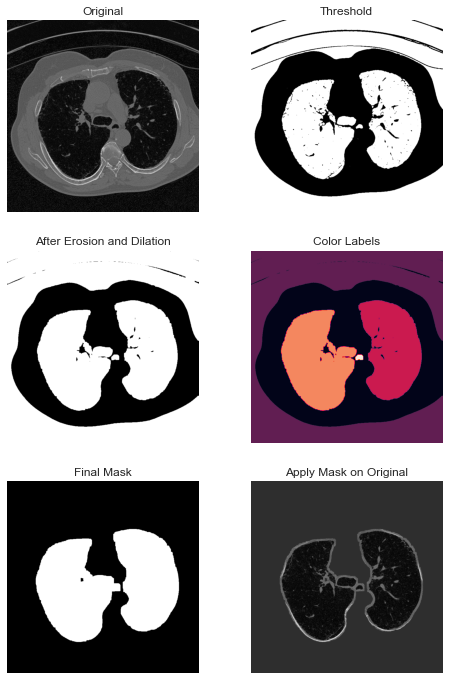

In [275]:
img = pydicom.dcmread('/Users/jesse/Documents/osic_kaggle/data/train/ID00421637202311550012437/22.dcm')
_, labels = make_lungmask(img.pixel_array, True)

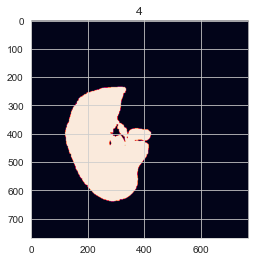

In [265]:
i = 4
plt.imshow(np.where(labels==i, labels, -1))
plt.title(f'{i}');

prop 3 area: 11.46, (106, 101, 403, 247)
prop 4 area: 8.46, (159, 279, 412, 434)


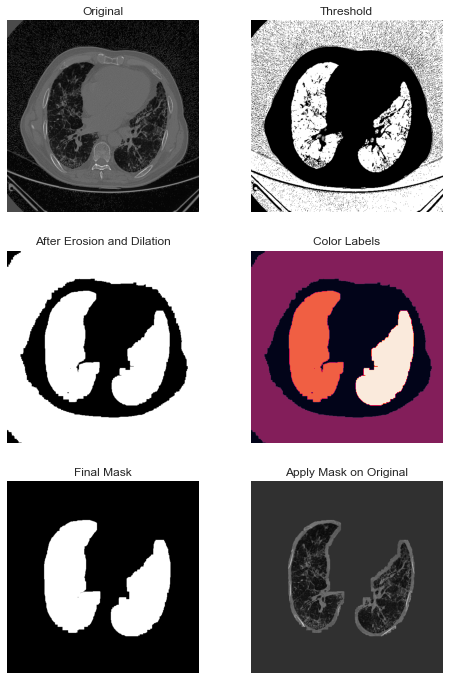

In [420]:
# check lungmask against random images
#p = random.choice(meta_data_df['Patient'].unique())
p = 'ID00296637202279895784347'
p_dicoms = [d for d in Path(os.path.join(TRAINING_DIR, p)).rglob('*.dcm')]
p_dicom = random.choice(p_dicoms)
img = pydicom.dcmread(p_dicom)

masked_img, mask_var, mask_pct, n_labels = make_lungmask(img.pixel_array, True)

# skip these:
bad_patients_dict = dict(
    'ID00014637202177757139317':'CTs are in a grey frame?'
)

In [421]:
print(mask_var)
print(mask_pct)
print(n_labels)
print(f'mask var is valid: {mask_var > .04}')
print(f'mask pct is valid: {mask_pct > .04}')
print(f'n_labels is valid: {n_labels < 10}')

0.1681
0.21380615234375
2
mask var is valid: True
mask pct is valid: True
n_labels is valid: True


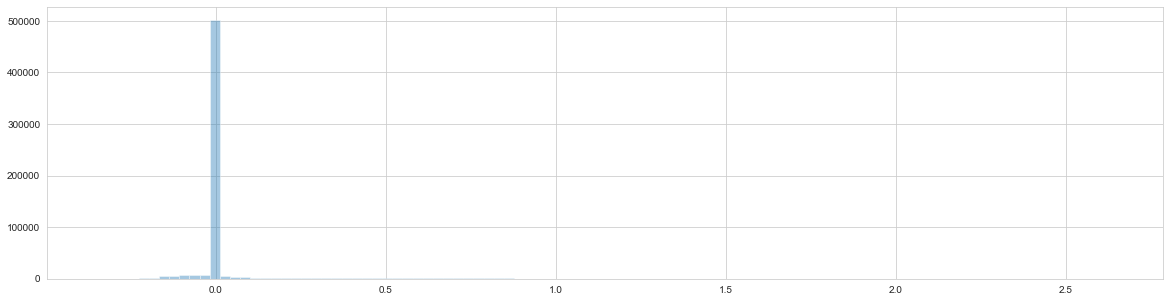

In [292]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.distplot(masked_img.flatten(), kde=False, bins=100);

prop 3 area: 14.44, (111, 49, 425, 238)
prop 4 area: 10.67, (223, 287, 427, 466)


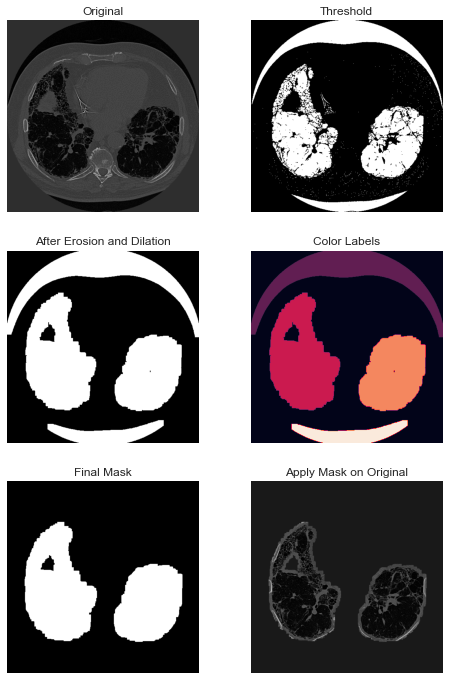

In [398]:
masked_img, mask_var, mask_pct, n_labels = make_lungmask(img.pixel_array, True)